In [1]:
with open('openai_orgchart.txt', 'r') as f_in:
    lines = f_in.readlines()
    lines = [line.rstrip() for line in lines]

In [2]:
import re

def find_last_capitalized_word(s):
    matches = re.findall(r'\b[A-Z][A-Za-z]*\b', s)
    if matches:
        last_match = matches[-1]
        index = len(matches) - 1
        return last_match, index
    else:
        return None, -1
    
def separate_string(s):
    last_match, index = find_last_capitalized_word(s)
    fs = s.split(last_match)
    f1 = fs[0]
    f2 = last_match + last_match.join(fs[1:])
    f1 = f1.strip()
    return f1, f2
    
def is_all_names_line(s):
    last_word = s.split(',')[-1].split(' ')[-1]
    if last_word[0].isupper():
        return True
    else:
        return False

In [3]:
s = 'Hello World aB gPU AB as AB AB'
# a1, a2 = find_last_capitalized_word(s)
# print(a1)
# print(s.split(a1))
print(s, '==>', separate_string(s))

Hello World aB gPU AB as AB AB ==> ('Hello World aB gPU', 'AB as AB AB')


In [4]:
from collections import defaultdict

tag_level_1_list = []

def construct_name_dict(lines):
    """A team meber can wear multiple hats"""
    tag_level_1 = None
    tag_level_2 = None
    name_dict = defaultdict(dict)
    for line_idx, line in enumerate(lines):
    #     print(line_idx)
        if not line: 
            # empty line, skip
            continue
        if line.startswith('-'):
            old_tag_level_1 = tag_level_1
            tag_level_1 = line.strip('- ')
            tag_level_1_list.append(tag_level_1)
            tag_level_2 = None
#             print('tag level 1 updated {} ==> {}'.format(old_tag_level_1, tag_level_1))
        elif line.startswith('\t- '):
            tag_level_2 = line.strip('\t- ')
        elif is_all_names_line(line.strip()):
            names = line.strip().split(', ')
            for name in names:
                hat = '{}--{}'.format(tag_level_1, tag_level_2)
                if 'hat' in name_dict[name]:
                    name_dict[name]['hat'].append(hat) 
                else:
                    name_dict[name]['hat'] = [hat]
                name_dict[name][tag_level_1] = name_dict[name].get(tag_level_1, 0) + 1
        else:
            # line with name and title
            line = line.strip()
            name, tag_level_3 = separate_string(line)
            hat = '{}--{}--{}'.format(tag_level_1, tag_level_2, tag_level_3)
            if 'hat' in name_dict[name]:
                name_dict[name]['hat'].append(hat) 
            else:
                name_dict[name]['hat'] = [hat]
            name_dict[name][tag_level_1] = name_dict[name].get(tag_level_1, 0) + 1
    #         print(name, ', ', tag_level_3)
    return name_dict

In [5]:
name_dict = construct_name_dict(lines[:])
full_name_list = list(name_dict.keys())
num_uniq_name = len(full_name_list)
print('GPT4 project has {} members in total'.format(num_uniq_name))

GPT4 project has 284 members in total


In [6]:
tag_level_1_list

['Pretraining',
 'Long context',
 'Vision',
 'Reinforcement Learning & Alignment',
 'Evaluation & analysis',
 'Deployment',
 'Additional contributions']

In [7]:
name_dict['Kai Xiao']

{'hat': ['Reinforcement Learning & Alignment--Dataset contributions',
  'Reinforcement Learning & Alignment--Model safety',
  'Reinforcement Learning & Alignment--Refusals',
  'Reinforcement Learning & Alignment--Foundational RLHF and InstructGPT work',
  'Evaluation & analysis--Core contributors--Safety evaluations co-lead',
  'Evaluation & analysis--Safety and policy evaluations',
  'Evaluation & analysis--System card & broader impacts analysis',
  'Additional contributions--Blog post & paper content'],
 'Reinforcement Learning & Alignment': 4,
 'Evaluation & analysis': 3,
 'Additional contributions': 1}

## For manual QA inspection

In [8]:
sorted(name_dict.keys())

['Aalok Mehta',
 'Adam Perelman',
 'Aditya Ramesh',
 'Adrien Ecoffet',
 'Akila Welihinda',
 'Alan Hickey',
 'Alec Radford',
 'Alethea Power',
 'Alex Paino',
 'Alex Passos',
 'Ali Kamali',
 'Alvin Wang',
 'Amin Tootoonchian',
 'Andrea Vallone',
 'Andrew Cann',
 'Andrew Kondrich',
 'Andrew Mayne',
 'Andrew Peng',
 'Andrey Mishchenko',
 'Angela Jiang',
 'Anna Makanju',
 'Anna-Luisa Brakman',
 'Aris Konstantinidis',
 'Arka Dhar',
 'Arun Vijayvergiya',
 'Arvind Neelakantan',
 'Ashley Pantuliano',
 'Ashvin Nair',
 'Atty Eleti',
 'Barret Zoph',
 'Ben Chess',
 'Ben Wang',
 'Benjamin Sokolowsky',
 'Bianca Martin',
 'Billie Jonn',
 'Bob McGrew',
 'Bob Rotsted',
 'Boris Power',
 'Brandon Houghton',
 'Brittany Carey',
 'Brooke Chan',
 'CJ Weinmann',
 'Cameron Raymond',
 'Carl Ross',
 'Carroll Wainwright',
 'Casey Chu',
 'Chak Ming Li',
 'Che Chang',
 'Chelsea Carlson',
 'Chelsea Voss',
 'Chester Cho',
 'Chong Zhan',
 'Chong Zhang',
 'Chris Hallacy',
 'Chris Hesse',
 'Christian Gibson',
 'Christina

## Most common last name and first name at OpenAI

In [9]:
surnames = [name.split(' ')[-1] for name in sorted(name_dict.keys())]
firstnames = [name.split(' ')[0] for name in sorted(name_dict.keys())]

In [10]:
from collections import Counter
print(Counter(surnames).most_common(10))
print(Counter(firstnames).most_common(10))

[('Chen', 4), ('Wang', 3), ('Kim', 3), ('Wu', 3), ('Pokorny', 3), ('Hickey', 2), ('Power', 2), ('Jiang', 2), ('Zhang', 2), ('Mossing', 2)]
[('David', 5), ('Michael', 5), ('Andrew', 4), ('Daniel', 4), ('Jeff', 3), ('Sam', 3), ('Alex', 2), ('Ben', 2), ('Bob', 2), ('Chelsea', 2)]


## Member hats count, as each member wears multiple hats

In [11]:
hats_count_dict = defaultdict()
num_hats = 0
for name in sorted(name_dict.keys()):
    hats_count_dict[name] = len(name_dict[name])
    num_hats += len(name_dict[name])
hats_per_capita = float(num_hats / num_uniq_name)
print('Total {} hats'.format(num_hats))
print('Each member wear {:.02f} hats'.format(hats_per_capita))

Total 751 hats
Each member wear 2.64 hats


In [42]:
# convert to pandas

import pandas as pd

df = pd.DataFrame.from_dict(name_dict, orient='index')
df['tech_hat'] = df['hat'].apply(lambda x: [hat for hat in x if not hat.startswith('Additional')])
df['num_hats'] = df['tech_hat'].apply(lambda x: len(x))
df
# 


,hat,Pretraining,Reinforcement Learning & Alignment,Deployment,Additional contributions,Vision,Evaluation & analysis,Long context,tech_hat,num_hats
Christopher Berner,[Pretraining--Core contributors--Supercomputin...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,[Pretraining--Core contributors--Supercomputin...,2
Greg Brockman,[Pretraining--Core contributors--Infrastructur...,4.0,2.0,1.0,1.0,NaN,NaN,NaN,[Pretraining--Core contributors--Infrastructur...,7
Trevor Cai,[Pretraining--Core contributors--Throughput le...,3.0,NaN,NaN,NaN,4.0,NaN,NaN,[Pretraining--Core contributors--Throughput le...,7
David Farhi,[Pretraining--Core contributors--Manager of op...,2.0,NaN,NaN,2.0,NaN,NaN,NaN,[Pretraining--Core contributors--Manager of op...,2
Chris Hesse,[Pretraining--Core contributors--Infrastructur...,3.0,NaN,NaN,NaN,2.0,NaN,NaN,[Pretraining--Core contributors--Infrastructur...,5
...,...,...,...,...,...,...,...,...,...,...
Preston Tuggle,[Additional contributions--Launch partners & p...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,[],0
Jake Berdine,[Additional contributions--Legal],NaN,NaN,NaN,1.0,NaN,NaN,NaN,[],0
Shino Jomoto,[Additional contributions--Security & privacy ...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,[],0
Morgan Grafstein,[Additional contributions--System administrati...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,[],0


In [43]:
df_top_player = df.sort_values('num_hats', ascending=False)
df_top_player

,hat,Pretraining,Reinforcement Learning & Alignment,Deployment,Additional contributions,Vision,Evaluation & analysis,Long context,tech_hat,num_hats
Raul Puri,[Vision--Core contributors--Overall vision co-...,NaN,NaN,1.0,NaN,6.0,3.0,NaN,[Vision--Core contributors--Overall vision co-...,10
Pamela Mishkin,[Reinforcement Learning & Alignment--Dataset c...,NaN,3.0,NaN,NaN,NaN,6.0,NaN,[Reinforcement Learning & Alignment--Dataset c...,9
Barret Zoph,[Reinforcement Learning & Alignment--Core cont...,NaN,7.0,NaN,NaN,NaN,2.0,NaN,[Reinforcement Learning & Alignment--Core cont...,9
Carroll Wainwright,[Reinforcement Learning & Alignment--Core cont...,NaN,6.0,NaN,NaN,NaN,3.0,NaN,[Reinforcement Learning & Alignment--Core cont...,9
Joost Huizinga,[Reinforcement Learning & Alignment--Core cont...,NaN,6.0,NaN,1.0,NaN,3.0,NaN,[Reinforcement Learning & Alignment--Core cont...,9
...,...,...,...,...,...,...,...,...,...,...
Niko Felix,[Additional contributions--Communications],NaN,NaN,NaN,1.0,NaN,NaN,NaN,[],0
Elie Georges,[Additional contributions--Communications],NaN,NaN,NaN,1.0,NaN,NaN,NaN,[],0
Anna Makanju,[Additional contributions--Communications],NaN,NaN,NaN,1.0,NaN,NaN,NaN,[],0
Elizabeth Proehl,[Additional contributions--Communications],NaN,NaN,NaN,1.0,NaN,NaN,NaN,[],0


In [44]:
df_top_player.columns

Index(['hat', 'Pretraining', 'Reinforcement Learning & Alignment',
       'Deployment', 'Additional contributions', 'Vision',
       'Evaluation & analysis', 'Long context', 'tech_hat', 'num_hats'],
      dtype='object')

In [48]:
import seaborn as sns
sns.set_theme()
import matplotlib.pylab as plt

plt.rcParams["figure.figsize"] = [8, 4]
plt.rcParams["figure.autolayout"] = True
plt.rcParams["figure.dpi"] = 200

Text(0.5, 1.0, 'Top contributors in GPT4 (by number of sub-areas)')

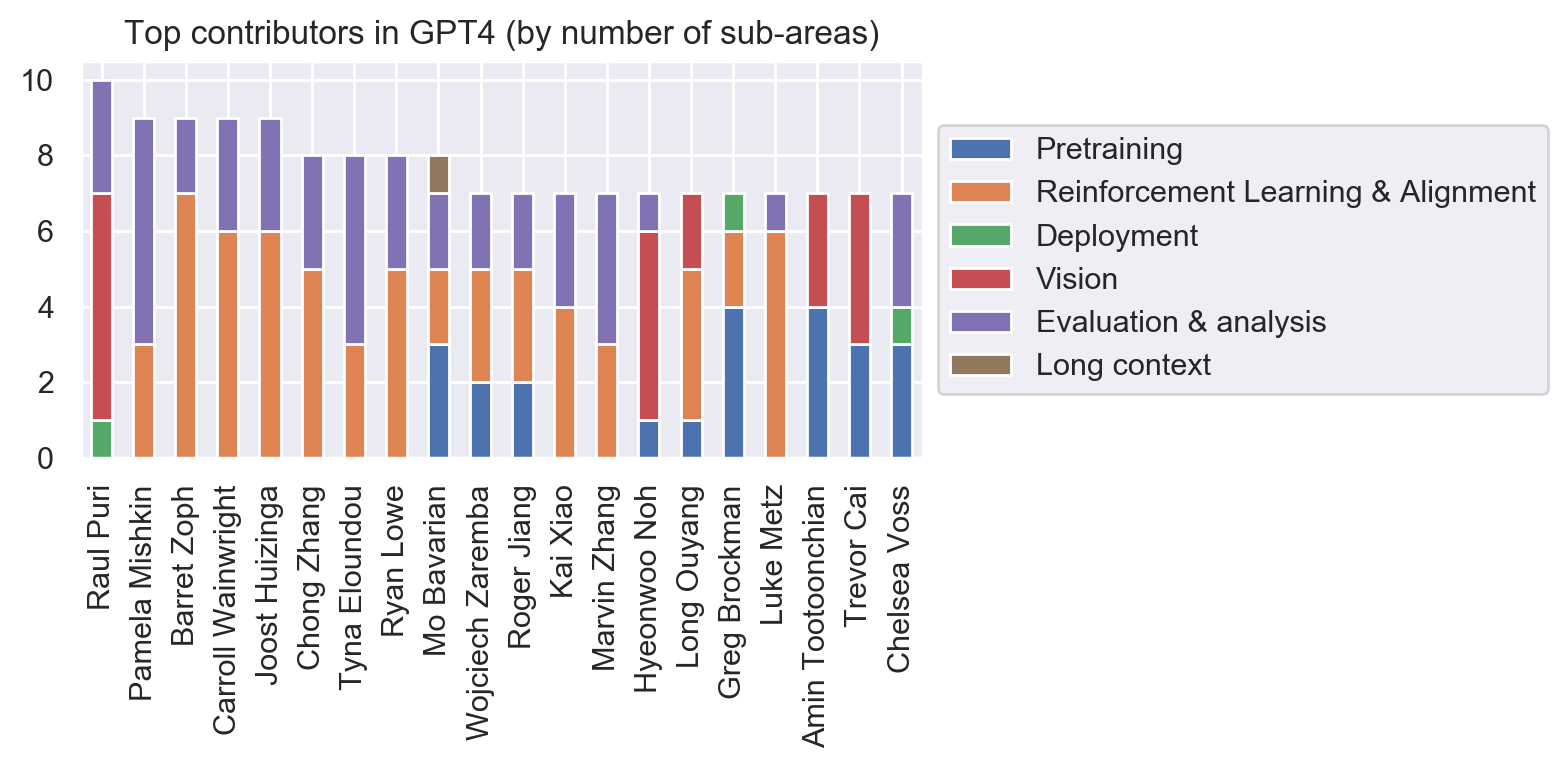

In [53]:
df_top_player[:20].plot(
    y=['Pretraining', 'Reinforcement Learning & Alignment',
       'Deployment', 'Vision',
       'Evaluation & analysis', 'Long context'], 
    kind='bar', stacked=True)
plt.legend(loc='center left', bbox_to_anchor= (1, 0.5))
plt.title('Top contributors in GPT4 (by number of sub-areas)')
